In [2]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import CelebA,ImageFolder
from PIL import Image
import torchvision.utils as vutils
from torchvision.transforms import transforms
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize the images
])

In [3]:
class CelebDataset(Dataset):
    def __init__(self,img_dir,transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)
    def __len__(self):
        return len(self.img_names)
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir,self.img_names[index])
        image = Image.open(img_path).convert('RGB')
        if(self.transform):
            image = self.transform(image)
        return image
         

In [ ]:
img = cv2.cvtColor(cv2.imread('./img_align_celeba/000001.jpg'),cv2.COLOR_BGR2RGB)
plt.imshow(img)

# prepare dataset

In [5]:
# celeb_dataset = CelebDataset(img_dir='img_align_celeba',transform=transform)

In [6]:
# batch_size = 32

In [7]:
# create a dataloader
# dataloader = DataLoader(celeb_dataset,batch_size=batch_size,shuffle=True)

In [8]:
# dataloader

In [4]:
# Number of workers for dataloader
workers = 2

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

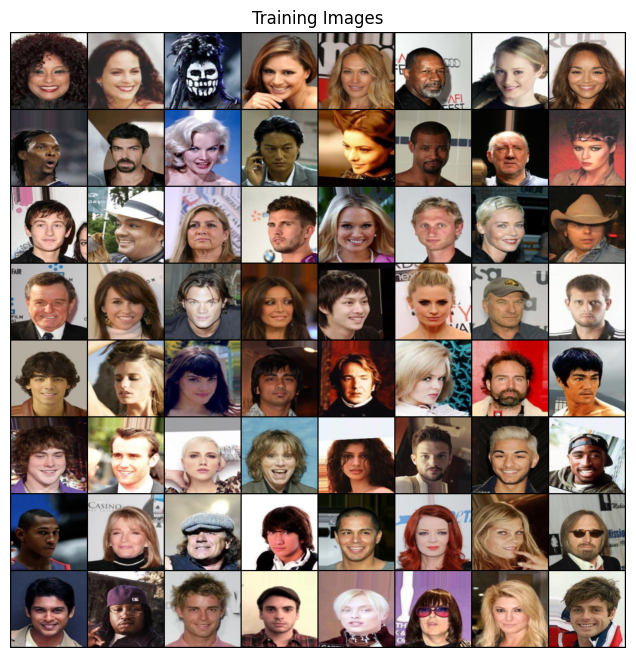

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = ImageFolder(root='./celeba',
                           transform=transforms.Compose([
                               transforms.Resize((128,128)),
                               transforms.CenterCrop((128,128)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [6]:
import torch.nn as nn
random_noise = 100
class Generator(nn.Module):
    def __init__(self,random_noise = 100) :
        super(Generator,self).__init__()
        self.fc = nn.Sequential(
            # 100 -> 16*16*2048
            nn.Linear(random_noise,16*16*2048),
            nn.BatchNorm1d(16*16*2048),
            nn.ReLU(True)
        )
        self.gen = nn.Sequential(
            # 16*16*2048 -> 32*32*1024
            nn.ConvTranspose2d(2048,1024,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            # 32*32*1024 -> 64*64*512
            nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # 64*64*512 -> 128*128*3
            nn.ConvTranspose2d(512,3,kernel_size=4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self,z):
        x = self.fc(z)
        # Reshape to (batch_size, 2048, 16, 16)
        x = x.view(-1,2048,16,16)
        return self.gen(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        # input 128*128*3 image -> feature map 64*64*512
        self.disc = nn.Sequential(
            nn.Conv2d(3,512,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True),

            nn.Conv2d(512,1024,4,2,1),
            nn.LeakyReLU(0.2,True),

            nn.Conv2d(1024,2048,4,2,1),
            nn.LeakyReLU(0.2,True)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048*16*16,1),
            nn.Sigmoid()
        )
    def forward(self,z):
        x = self.disc(z)
        return self.fc(x)    

In [8]:
gen = Generator()
disc = Discriminator()

In [9]:
device = 'cuda:0' if torch.cuda.is_available()else'cpu'

In [10]:
epochs = 10
lr = 2e-4
b1=0.5
b2=0.999

In [11]:
adverserial_loss = nn.BCELoss()

In [12]:
from torch.optim import Adam

gen_opt = Adam(gen.parameters(),lr=lr,betas=(b1,b2))
disc_opt = Adam(disc.parameters(),lr=lr,betas=(b1,b2))


In [19]:
gen.to(device)
disc.to(device)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=524288, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [21]:
try:
    for e in range(epochs):
        for i, (imgs, _) in enumerate(dataloader):  # Use _ to ignore the labels
            imgs = imgs.to(device)
            current_batch_size = imgs.size(0)

            real_labels = torch.ones(current_batch_size, 1).to(device)
            fake_labels = torch.zeros(current_batch_size, 1).to(device)

            # ======================
            # Train Discriminator
            # ======================
            disc_opt.zero_grad()

            # Generate fake images
            z = torch.randn(current_batch_size, random_noise).to(device)
            fake_images = gen(z)

            # Compute losses for real and fake images
            fake_loss = adverserial_loss(disc(fake_images), fake_labels)
            real_loss = adverserial_loss(disc(imgs), real_labels)

            # Total discriminator loss
            disc_loss = fake_loss + real_loss
            disc_loss.backward()
            disc_opt.step()

            # ======================
            # Train Generator
            # ======================
            gen_opt.zero_grad()

            # Generate fake images again
            z = torch.randn(current_batch_size, random_noise).to(device)
            fake_images = gen(z)
            disc_fake = disc(fake_images)
            
            # Generator wants discriminator to think its images are real
            gen_loss = adverserial_loss(disc_fake, real_labels)
            gen_loss.backward()
            gen_opt.step()

        # Print losses after each epoch
        print(f"Epoch {e + 1}/{epochs}: | D Loss: {disc_loss.item():.4f} | G Loss: {gen_loss.item():.4f}")
    
except Exception as e:
    print(e.args[0])


KeyboardInterrupt: 